In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
df = pd.read_csv("tech_mna_with_risk.csv")
df.head()

,acquirer,target,deal_size_m_usd,completed,blocked,stock_return_6m,esg_acquirer,esg_target,synergy_y1,synergy_y2,synergy_y3,industry_match,public_target,region_type,payment_method,regulatory_risk_score
0,Meta,WhatsApp,19000,1,0,0.12,6.0,5.5,552,682,745,1,1,International,Stock,9
1,Google,Fitbit,2100,1,0,0.04,6.8,7.2,543,681,768,1,1,International,Stock,6
2,Microsoft,GitHub,7500,1,0,0.15,7.5,8.0,348,431,567,1,1,International,Stock,6
3,Amazon,Zoox,1200,1,0,-0.05,6.8,7.1,212,318,411,1,1,International,Stock,6
4,Zomato,Blinkit,570,1,0,-0.02,5.9,6.1,580,690,749,1,1,International,Stock,6


In [36]:
def classify_success(row):
    if not row['completed'] or row['blocked']:
        return 'Failure'
    elif row['stock_return_6m'] > 0:
        return 'Success'
    else:
        return 'Neutral'

df['success_label'] = df.apply(classify_success, axis=1)
print('success_label exists?' , 'success_label' in df.columns)
print(df.columns.tolist())



success_label exists? True
['acquirer', 'target', 'deal_size_m_usd', 'completed', 'blocked', 'stock_return_6m', 'esg_acquirer', 'esg_target', 'synergy_y1', 'synergy_y2', 'synergy_y3', 'industry_match', 'public_target', 'region_type', 'payment_method', 'regulatory_risk_score', 'success_label', 'regulatory_risk', 'roi', 'payback_period', 'composite_success_label', 'esg_effect']


In [37]:

def esg_impact(acq, tgt):
    combined = (acq + tgt) / 2
    if combined > acq:
        return 'Improved'
    elif combined < acq:
        return 'Declined'
    else:
        return 'Neutral'

df['esg_effect'] = df.apply(lambda row: esg_impact(row['esg_acquirer'], row['esg_target']), axis=1)


In [4]:
def index_flag(size):
    if size > 10000:
        return 'Large Cap Eligible'
    elif size > 2000:
        return 'Mid Cap Eligible'
    else:
        return 'Small Cap / Not Eligible'

df['index_impact'] = df['deal_size_m_usd'].apply(index_flag)


In [21]:
def compute_reg_risk(row):
    score = 1  # base score
    if row['deal_size_m_usd'] > 10000:
        score += 3  # large deal, more scrutiny
    if row['industry_match'] == 1:
        score += 2  # overlap = antitrust concern
    if row['public_target'] == 1:
        score += 1  # public = more visible deal
    if row['region_type'] == 'International':
        score += 1  # cross-border = compliance complications
    if row['payment_method'] == 'Stock':
        score += 1  # dilution risks can be flagged
    return min(score, 10)
df['regulatory_risk'] = df.apply(compute_reg_risk, axis=1)

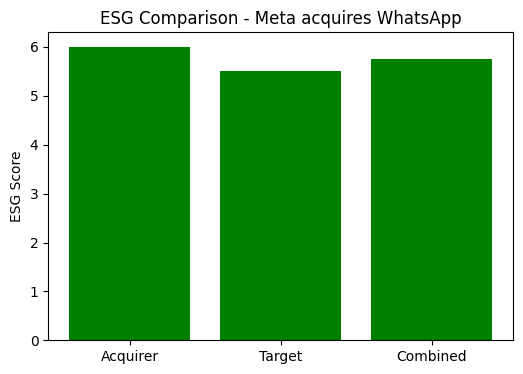

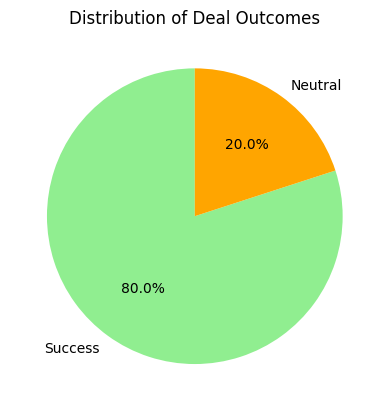

In [ ]:
deal = df.iloc[0]
esg_scores = [deal['esg_acquirer'], deal['esg_target'], (deal['esg_acquirer'] + deal['esg_target'])/2]
labels = ['Acquirer', 'Target', 'Combined']
plt.figure(figsize=(6,4))
plt.bar(labels, esg_scores, color='green')
plt.title(f"ESG Comparison - {deal['acquirer']} acquires {deal['target']}")
plt.ylabel("ESG Score")
plt.show()

## Pie Chart of Success Types
df['success_label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'orange', 'lightcoral'])
plt.title("Distribution of Deal Outcomes")
plt.ylabel('')
plt.show()

In [27]:
def compute_financials(row):
    synergies = [row['synergy_y1'], row['synergy_y2'], row['synergy_y3']]
    total_synergy = sum(synergies)
    roi = (total_synergy - row['deal_size_m_usd']) / row['deal_size_m_usd']
    cumulative = 0
    for i, val in enumerate(synergies):
        cumulative += val
        if cumulative >= row['deal_size_m_usd']:
            return roi, f"Payback in Year {i+1}"
    return roi, "Not Recovered"

roi_list = []
payback_list = []
for _, row in df.iterrows():
    roi, payback = compute_financials(row)
    roi_list.append(roi)
    payback_list.append(payback)

df['roi'] = roi_list
df['payback_period'] = payback_list



Deal Success by MSCI Index Eligibility

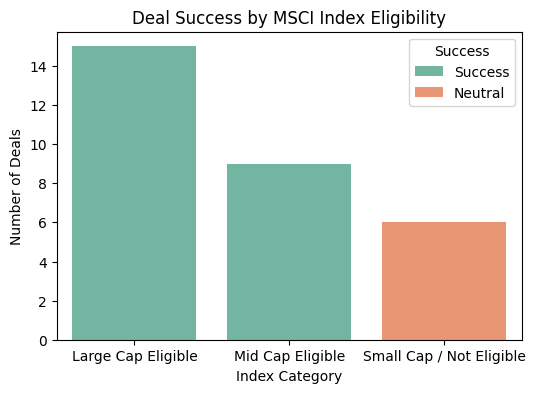

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='index_impact', hue='success_label', palette='Set2')
plt.title("Deal Success by MSCI Index Eligibility")
plt.xlabel("Index Category")
plt.ylabel("Number of Deals")
plt.legend(title="Success")
plt.show()


Average ROI by Deal Success Type

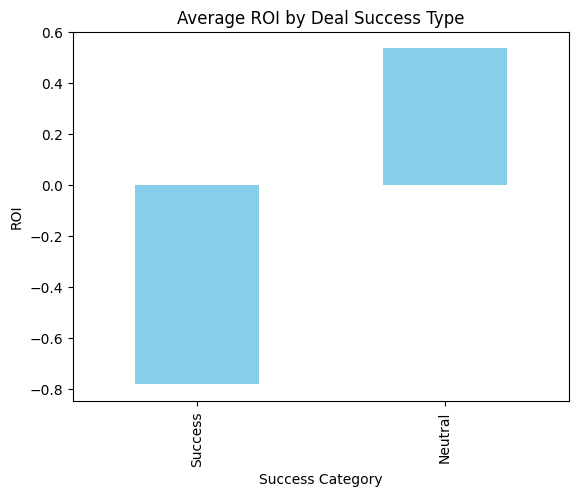

In [8]:
avg_roi = df.groupby('success_label')['roi'].mean().sort_values()
avg_roi.plot(kind='bar', color='skyblue')
plt.title("Average ROI by Deal Success Type")
plt.ylabel("ROI")
plt.xlabel("Success Category")
plt.grid(False, axis='y')
plt.show()


Composite Deal Success Classification

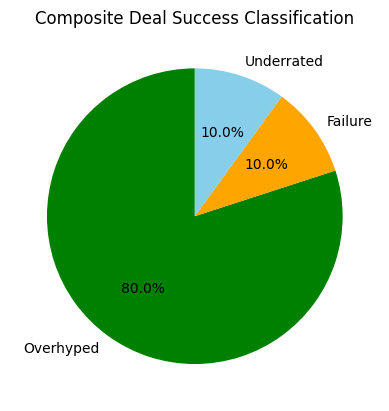

In [28]:
def classify_composite_success(row):
    if row['stock_return_6m'] > 0 and row['roi'] > 0:
        return 'Well performed'
    elif row['stock_return_6m'] > 0 and row['roi'] <= 0:
        return 'Overhyped'
    elif row['stock_return_6m'] <= 0 and row['roi'] > 0:
        return 'Underrated'
    else:
        return 'Failure'

df['composite_success_label'] = df.apply(classify_composite_success, axis=1)
df['composite_success_label'].value_counts().plot.pie(
    autopct='%1.1f%%', colors=['green', 'orange', 'skyblue', 'red'], startangle=90
)
plt.title("Composite Deal Success Classification")
plt.ylabel("")
plt.show()

Distribution of Payback Periods

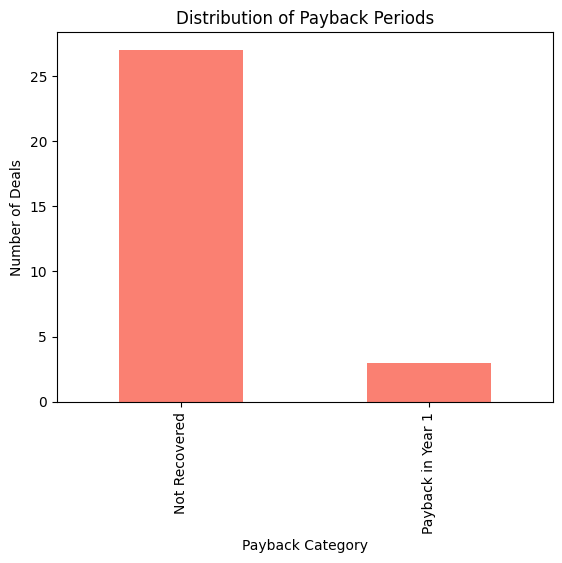

In [29]:
df['payback_period'].value_counts().plot(kind='bar', color='salmon')
plt.title("Distribution of Payback Periods")
plt.xlabel("Payback Category")
plt.ylabel("Number of Deals")
plt.xticks(rotation=90)
plt.show()


ESG Outcome Distribution

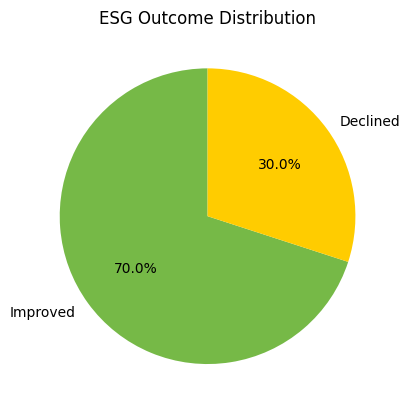

In [33]:
df['esg_effect'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#76b947', '#ffcc00', '#e60000'])
plt.title("ESG Outcome Distribution")
plt.ylabel('')
plt.show()


Stock Return vs Deal Size

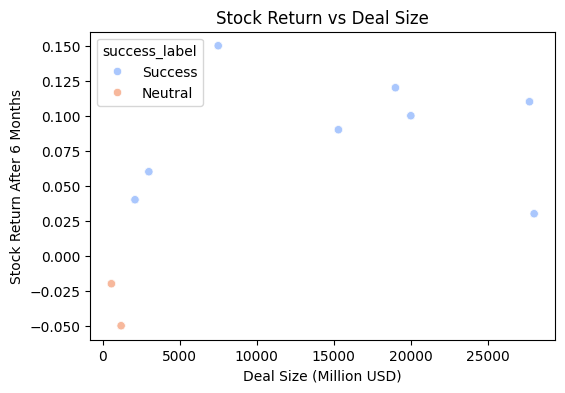

In [34]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='deal_size_m_usd', y='stock_return_6m', hue='success_label', palette='coolwarm')
plt.title("Stock Return vs Deal Size")
plt.xlabel("Deal Size (Million USD)")
plt.ylabel("Stock Return After 6 Months")
plt.grid(False)
plt.show()


Regulatory Risk Distribution

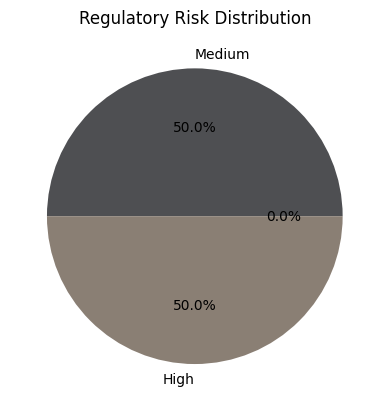

In [35]:

risk_bins = pd.cut(df['regulatory_risk_score'], bins=[0, 3, 6, 10], labels=['Low', 'Medium', 'High'])
risk_bins.value_counts().plot.pie(autopct='%1.1f%%', colors=["#4e4f52", "#8a7f74", "#666161"])
plt.title("Regulatory Risk Distribution")
plt.ylabel('')
plt.show()